# Notebook 02: Chunking Strategy & Embedding Preview

## Goal

Split cleaned text into overlapping chunks, then generate embeddings for a sample to verify the pipeline.


## Chunking Strategy Trade-offs

### Size

- **Too small** (< 400 chars): Loses context, may break sentences
- **Too large** (> 1200 chars): Dilutes relevance, harder to retrieve precise passages
- **Sweet spot**: ~800 characters balances context and precision

### Overlap

- **No overlap**: Risk of splitting important passages across chunk boundaries
- **Large overlap** (> 50%): Redundant storage, slower retrieval
- **Moderate overlap** (~15%): Preserves continuity without excessive redundancy

### Our Approach

1. Split into paragraphs first (preserve natural boundaries)
2. Accumulate paragraphs until we reach `chunk_size` characters
3. Slide by `chunk_size - chunk_overlap` to create overlapping windows
4. Attach metadata: book name, paragraph indices, character span


## Why sentence-transformers MiniLM?

We use `sentence-transformers/all-MiniLM-L6-v2` because:

- **Speed**: Fast encoding on CPU (no GPU required)
- **Quality**: Good semantic similarity for literary text
- **Size**: Small model (~80MB), easy to load
- **Normalization**: Supports normalized embeddings for cosine similarity / inner product in FAISS


## Normalization for FAISS

FAISS supports two distance metrics:

- **L2 (Euclidean)**: Requires no normalization
- **Inner Product (IP)**: Requires normalized vectors (unit length)

We'll use **Inner Product** with normalized embeddings because:

- Equivalent to cosine similarity for normalized vectors
- Faster search in FAISS for normalized vectors
- Better semantic matching for text


## Step 1: Load Cleaned Text

Load the cleaned text from the previous notebook.


In [10]:
# Load cleaned text from data/interim/
# Use the book name from config to construct the file path.
import yaml
from pathlib import Path

def load_config(path="../configs/app.yaml"):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    return config

config = load_config()
book_name = config['book']

# Construct file path based on config
cleaned_file_path = Path(f"../data/interim/{book_name}_cleaned.txt")

if not cleaned_file_path.exists():
    raise FileNotFoundError(
        f"Cleaned text file not found: {cleaned_file_path}\n"
        f"Please run notebook 01 with book='{book_name}' in configs/app.yaml first."
    )

with open(cleaned_file_path, 'r', encoding='utf-8') as file:
    cleaned_text_dorian = file.read()

with open(cleaned_file_path, 'r', encoding='utf-8') as file:
    cleaned_text_iliad = file.read()

print(f"✅ Loaded cleaned text for '{book_name}' from: {cleaned_file_path}")
print(f"   Text length: {len(cleaned_text_dorian):,} characters")


✅ Loaded cleaned text for 'dorian' from: ../data/interim/dorian_cleaned.txt
   Text length: 429,167 characters


## Step 2: Split into Paragraphs

Split the cleaned text into paragraphs (double newline boundaries).


In [11]:
# === TODO (you code this) ===
# Split cleaned text into paragraphs.
# Acceptance: list[str], len>100 for full books.

import sys
from pathlib import Path
import importlib

sys.path.append(str(Path("..").resolve()))
from src import chunk
importlib.reload(chunk)  # Reload to get latest changes
from src.chunk import split_into_paragraphs

# Call split_into_paragraphs and verify the result.
paragraphs = split_into_paragraphs(cleaned_text_dorian)
print(f"✅ Split into {len(paragraphs)} paragraphs")

# Preview first few paragraphs
print(f"\nFirst 3 paragraphs (showing first 200 chars of each):")
for i, para in enumerate(paragraphs[:3], 1):
    preview = para[:200] + "..." if len(para) > 200 else para
    print(f"\n[{i}] {preview}")



✅ Split into 1525 paragraphs

First 3 paragraphs (showing first 200 chars of each):

[1] The Picture of Dorian Gray

[2] by Oscar Wilde

[3] Contents


## Step 3: Create Overlapping Chunks

Chunk paragraphs into fixed-size overlapping segments with metadata.


In [12]:
# === TODO (you code this) ===
# Chunk paragraphs into fixed-size overlapping chunks with metadata.
# Acceptance: list[dict] with 'id','text','meta'.
import sys
from pathlib import Path
import importlib

sys.path.append(str(Path("..").resolve()))
from src import chunk
importlib.reload(chunk)  # Reload to get latest changes
from src.chunk import chunk_paragraphs

# Use chunk_size and chunk_overlap from config.
# Verify chunk structure: each should have id, text, and metadata.
config = load_config()

# Create chunks for the current book (from config)
print(f"Creating chunks for '{book_name}'...")
chunks = chunk_paragraphs(paragraphs, config['chunk_size'], config['chunk_overlap'], book_name)

print(f"✅ Created {len(chunks)} chunks for '{book_name}'")
print(f"   Chunk size target: {config['chunk_size']} chars")
print(f"   Overlap: {config['chunk_overlap']} chars\n")

# Verify chunk structure and show examples
if len(chunks) > 0:
    print("Chunk structure example (first chunk):")
    first_chunk = chunks[0]
    print(f"  ID: {first_chunk['id']}")
    print(f"  Text length: {len(first_chunk['text'])} characters")
    print(f"  Metadata: {first_chunk['meta']}")
    print(f"\n  Text preview (first 300 chars):")
    print(f"  {first_chunk['text'][:300]}...")
    
    if len(chunks) > 1:
        print(f"\n\nSecond chunk (to verify overlap):")
        second_chunk = chunks[1]
        print(f"  ID: {second_chunk['id']}")
        print(f"  Text length: {len(second_chunk['text'])} characters")
        print(f"  Metadata: {second_chunk['meta']}")
        print(f"\n  Text preview (first 300 chars):")
        print(f"  {second_chunk['text'][:300]}...")

print("\nCreating chunks for 'dorian'...")
chunks_dorian = chunk_paragraphs(paragraphs, config['chunk_size'], config['chunk_overlap'], 'dorian')
print(f"✅ Created {len(chunks_dorian)} chunks for 'dorian'")

print("\nCreating chunks for 'iliad'...")
chunks_iliad = chunk_paragraphs(paragraphs, config['chunk_size'], config['chunk_overlap'], 'iliad')
print(f"✅ Created {len(chunks_iliad)} chunks for 'iliad'")

# Print chunk 1 for dorian
print("\nChunk 1 for dorian:")
print(chunks_dorian[1])




Creating chunks for 'dorian'...
📚 Chunking 'dorian': 1525 paragraphs, size=800, overlap=120
  Chunk 0: paras 0-7, 875 chars (0.5% complete)
  Chunk 1: paras 8-10, 1482 chars (0.7% complete)
  Chunk 2: paras 11-15, 1302 chars (1.0% complete)
  Chunk 3: paras 16-18, 1172 chars (1.2% complete)
  Chunk 4: paras 19-20, 855 chars (1.4% complete)
  Chunk 5: paras 21-24, 1610 chars (1.6% complete)
  Chunk 6: paras 25-25, 950 chars (1.7% complete)
  Chunk 7: paras 26-30, 1410 chars (2.0% complete)
  Chunk 8: paras 31-33, 893 chars (2.2% complete)
  Chunk 9: paras 34-40, 823 chars (2.7% complete)
  Chunk 10: paras 41-46, 1041 chars (3.1% complete)
  Chunk 11: paras 47-47, 1487 chars (3.1% complete)
  Chunk 12: paras 48-51, 1517 chars (3.4% complete)
  Chunk 13: paras 52-54, 887 chars (3.6% complete)
  Chunk 14: paras 55-58, 1255 chars (3.9% complete)
  Chunk 15: paras 59-64, 1043 chars (4.3% complete)
  Chunk 16: paras 65-66, 1108 chars (4.4% complete)
  Chunk 17: paras 67-69, 2418 chars (4.6% c

## Step 4: Embed Sample Chunks

Generate embeddings for a small sample to verify shape and variance.


In [13]:
# === TODO (you code this) ===
# Embed a small sample of chunks to sanity-check shape and variance.
# Acceptance: embedding array shape == (n_sample, d).

import sys
from pathlib import Path
import importlib

sys.path.append(str(Path("..").resolve()))
from src import embed_index
importlib.reload(embed_index)  # Reload to get latest changes
from src.embed_index import embed_texts

load_config()

# Take first 10 chunks, embed them, check shape and maybe compute pairwise similarity.
first_10_chunks = chunks_dorian[:10]
embeddings, model = embed_texts(first_10_chunks, config['model'])

# Check shape and maybe compute pairwise similarity
print(f"✅ Embedding shape: {embeddings.shape}")




modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Embedding shape: (10, 384)


## Optional: 2D Projection Visualization

Use PCA or t-SNE to project embeddings to 2D and visualize chunk similarity. This helps verify that semantically similar chunks cluster together.


Projecting 10 embeddings to 2D with perplexity=9
📊 Saved visualization to ../images/tsne_embeddings.png


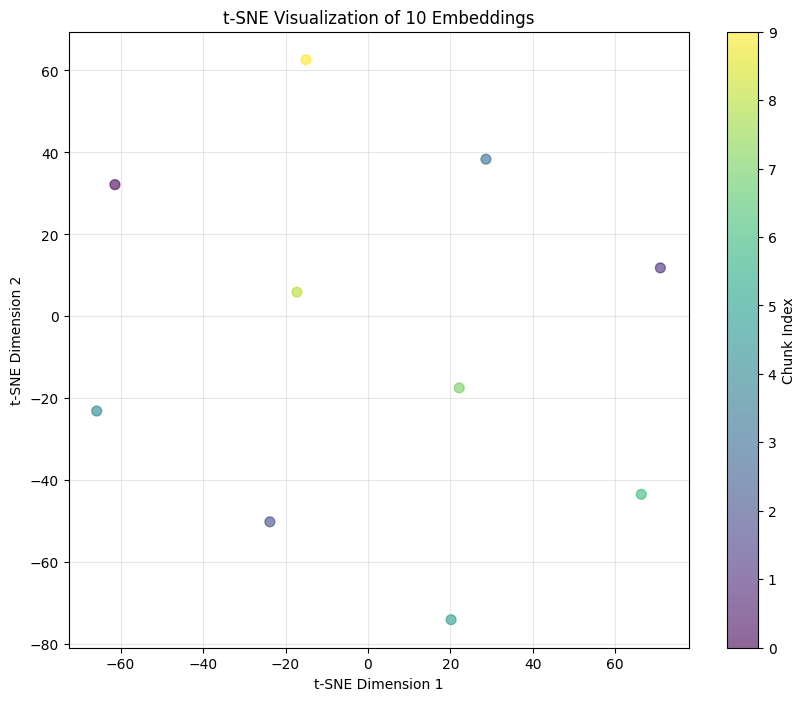

In [16]:
# Optional: 2D projection of embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Project and plot embeddings
# Note: perplexity must be less than n_samples
n_samples = embeddings.shape[0]
perplexity = min(30, max(5, n_samples - 1))  # Use 5-30, but less than n_samples

print(f"Projecting {n_samples} embeddings to 2D with perplexity={perplexity}")

tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
# Color by index to see different chunks
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(n_samples), cmap='viridis', s=50, alpha=0.6)
plt.colorbar(label='Chunk Index')
plt.title(f't-SNE Visualization of {n_samples} Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)

# Save figure to images folder
images_dir = Path("../images")
images_dir.mkdir(exist_ok=True)
plt.savefig(images_dir / "tsne_embeddings.png", dpi=150, bbox_inches='tight')
print(f"📊 Saved visualization to {images_dir / 'tsne_embeddings.png'}")

plt.show()



## Token Coverage vs. Character Chunks

**Note**: We're using character-based chunking (not token-based). This is simpler but may split tokens in some edge cases. For production, consider token-aware chunking (e.g., using a tokenizer to respect word boundaries).

For this project, character chunks work well because:

- Literary text has consistent word boundaries
- Simpler implementation
- Overlap mitigates boundary issues


## Summary

At this point, you should have:

- ✅ Paragraphs split from cleaned text
- ✅ Overlapping chunks with metadata
- ✅ Sample embeddings verified (correct shape, reasonable variance)

**Next notebook**: Build the full FAISS index and test retrieval.
